Surprise is a package that defines a few algorithms for recommendations. It also has some overhead that defines a few datasets like movielens.

In [1]:
from matplotlib import pyplot as plt
from scipy.stats import spearmanr

from surprise import SVD
from surprise import Dataset
from surprise.model_selection import cross_validate

# Load the movielens-100k dataset (download it if needed).
data = Dataset.load_builtin('ml-100k')

Below is the normal way to use the package

In [2]:
# Use the famous SVD algorithm.
algo = SVD()

# Run 5-fold cross-validation and print results.
cross_validate(algo, data, measures=['RMSE', 'MAE'], cv=5, verbose=True)

Evaluating RMSE, MAE of algorithm SVD on 5 split(s).

                  Fold 1  Fold 2  Fold 3  Fold 4  Fold 5  Mean    Std     
RMSE (testset)    0.9367  0.9313  0.9355  0.9379  0.9373  0.9358  0.0023  
MAE (testset)     0.7373  0.7343  0.7411  0.7362  0.7403  0.7379  0.0025  
Fit time          3.69    3.60    3.64    3.58    3.80    3.66    0.08    
Test time         0.10    0.14    0.13    0.09    0.14    0.12    0.02    


{'test_rmse': array([0.9367456 , 0.93134974, 0.93546718, 0.93786689, 0.93733635]),
 'test_mae': array([0.73728358, 0.73432837, 0.74114499, 0.73622986, 0.74027263]),
 'fit_time': (3.686634063720703,
  3.601262092590332,
  3.64390230178833,
  3.5820579528808594,
  3.802121162414551),
 'test_time': (0.09624385833740234,
  0.13902997970581055,
  0.13438725471496582,
  0.09456992149353027,
  0.14348387718200684)}

It's essentially doing the below code

In [3]:
import surprise
cv = surprise.model_selection.split.get_cv(5)
out = cv.split(data)
trainset, testset = next(out)
algo = SVD()
algo.fit(trainset)
predictions = algo.test(testset)
train_predictions = algo.test(trainset.build_testset())

In [4]:
measures = ['rmse', 'mae']
test_measures = dict()
train_measures = dict()
for m in measures:
    f = getattr(surprise.accuracy, m.lower())
    test_measures[m] = f(predictions, verbose=0)
    train_measures[m] = f(train_predictions, verbose=0)
print(test_measures)
print(train_measures)

{'rmse': 0.9278257405885186, 'mae': 0.733004594544204}
{'rmse': 0.687181269516791, 'mae': 0.544350212411448}


SpearmanrResult(correlation=0.5449173327331677, pvalue=0.0)


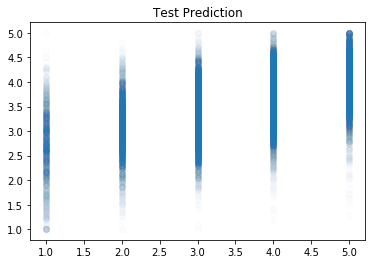

In [5]:
true_ratings = [i[2] for i in testset]
pred_ratings = [i.est for i in predictions]
plt.scatter(true_ratings, pred_ratings, alpha=.01)
plt.title('Test Prediction')
print(spearmanr(true_ratings, pred_ratings))

SpearmanrResult(correlation=0.8063089091006884, pvalue=0.0)


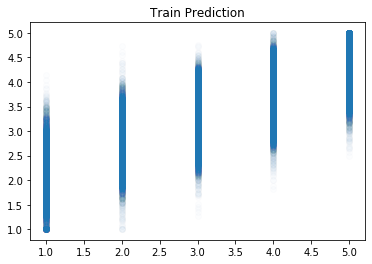

In [6]:
true_ratings = [i[2] for i in trainset.build_testset()]
pred_ratings = [i.est for i in train_predictions]
plt.scatter(true_ratings, pred_ratings, alpha=.01)
plt.title('Train Prediction')
print(spearmanr(true_ratings, pred_ratings))

## Use surprise data with my matrix factorization

Above is a close form SVD solution. Below is doing the same thing with gradient descent. Works comparably. See matrix_factorization.ipynb for more details

In [7]:
from models import MatrixFactorization
from utils import make_train_step, predict
import torch

In [8]:
def convert_to_tensors(surprise_data):
    data = list(zip(*surprise_data))
    tensors = [torch.LongTensor(list(map(int, data[0]))),
              torch.LongTensor(list(map(int, data[1]))),
              torch.FloatTensor(list(map(int, data[2])))]
    return torch.utils.data.TensorDataset(*tensors)

In [9]:
traindata = trainset.build_testset()
testdata = testset
torch_traindata = convert_to_tensors(traindata)
torch_testdata = convert_to_tensors(testdata)

In [15]:
model = MatrixFactorization(trainset.n_users+100,
                           trainset.n_items+100,
                           8, False, y_range=[1,5])
loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())
train_step = make_train_step(model, loss_fun, optimizer)

In [16]:
train_loader = torch.utils.data.DataLoader(torch_traindata, shuffle=True,
                                           batch_size=64)
n_epochs = 50
history = []
stats = {}
for epoch in range(n_epochs):
    tracked_loss = 0
    for users, items, ratings in train_loader:
        # calculate loss
        tracked_loss += train_step(users, items, ratings)
    train_perf = tracked_loss / len(train_loader)
    stats['train_loss'] = train_perf
    stats['epoch'] = epoch
    print(stats)
    history.append(stats)

{'train_loss': 3.439802710914612, 'epoch': 0}
{'train_loss': 3.1447646490097045, 'epoch': 1}
{'train_loss': 2.848825978755951, 'epoch': 2}
{'train_loss': 2.5696220905303955, 'epoch': 3}
{'train_loss': 2.317337716007233, 'epoch': 4}
{'train_loss': 2.095367346572876, 'epoch': 5}
{'train_loss': 1.9021816367149353, 'epoch': 6}
{'train_loss': 1.7316821506500244, 'epoch': 7}
{'train_loss': 1.57627525434494, 'epoch': 8}
{'train_loss': 1.4302829826831818, 'epoch': 9}
{'train_loss': 1.2945686710357667, 'epoch': 10}
{'train_loss': 1.1752450360298157, 'epoch': 11}
{'train_loss': 1.078054022693634, 'epoch': 12}
{'train_loss': 1.002957525730133, 'epoch': 13}
{'train_loss': 0.9458364771604538, 'epoch': 14}
{'train_loss': 0.9015548832654953, 'epoch': 15}
{'train_loss': 0.8664626097202301, 'epoch': 16}
{'train_loss': 0.8375541843891143, 'epoch': 17}
{'train_loss': 0.8131050805330277, 'epoch': 18}
{'train_loss': 0.7918966258764267, 'epoch': 19}
{'train_loss': 0.7731209965705872, 'epoch': 20}
{'train_lo

In [17]:
test_loader = torch.utils.data.DataLoader(torch_testdata, shuffle=False,
                                           batch_size=64)

In [18]:
preds, true = predict(model, test_loader)
print('Test Error: %s' % loss_fun(preds, true).item())

Test Error: 0.9739887118339539


SpearmanrResult(correlation=0.5017625844886872, pvalue=0.0)


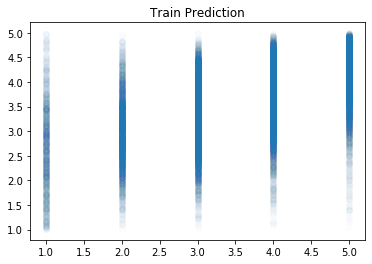

In [19]:
plt.scatter(true, preds.detach(), alpha=.01)
plt.title('Train Prediction')
print(spearmanr(true, preds.detach()))

Let's add bias into the mix

In [20]:
model = MatrixFactorization(trainset.n_users+100,
                           trainset.n_items+100,
                           8, True, y_range=[1,5])
loss_fun = torch.nn.MSELoss()
optimizer = torch.optim.AdamW(model.parameters())
train_step = make_train_step(model, loss_fun, optimizer)

In [21]:
train_loader = torch.utils.data.DataLoader(torch_traindata, shuffle=True,
                                           batch_size=64)
n_epochs = 50
history = []
stats = {}
for epoch in range(n_epochs):
    tracked_loss = 0
    for users, items, ratings in train_loader:
        # calculate loss
        tracked_loss += train_step(users, items, ratings)
    train_perf = tracked_loss / len(train_loader)
    stats['train_loss'] = train_perf
    stats['epoch'] = epoch
    print(stats)
    history.append(stats)

{'train_loss': 3.567702280807495, 'epoch': 0}
{'train_loss': 3.1491171073913575, 'epoch': 1}
{'train_loss': 2.750940989971161, 'epoch': 2}
{'train_loss': 2.393228237915039, 'epoch': 3}
{'train_loss': 2.083077149963379, 'epoch': 4}
{'train_loss': 1.8224457143306731, 'epoch': 5}
{'train_loss': 1.607092132139206, 'epoch': 6}
{'train_loss': 1.4303569345474243, 'epoch': 7}
{'train_loss': 1.286480837059021, 'epoch': 8}
{'train_loss': 1.1702667605400086, 'epoch': 9}
{'train_loss': 1.0764974133491516, 'epoch': 10}
{'train_loss': 1.0009640278577805, 'epoch': 11}
{'train_loss': 0.9402001291036606, 'epoch': 12}
{'train_loss': 0.8913685619831085, 'epoch': 13}
{'train_loss': 0.8518273936271668, 'epoch': 14}
{'train_loss': 0.8196943888902665, 'epoch': 15}
{'train_loss': 0.7932841807842255, 'epoch': 16}
{'train_loss': 0.7710562094688416, 'epoch': 17}
{'train_loss': 0.7522568541765213, 'epoch': 18}
{'train_loss': 0.7357921396970749, 'epoch': 19}
{'train_loss': 0.7212243744373321, 'epoch': 20}
{'train_

In [22]:
test_loader = torch.utils.data.DataLoader(torch_testdata, shuffle=False,
                                           batch_size=64)

In [23]:
preds, true = predict(model, test_loader)
print('Test Error: %s' % loss_fun(preds, true).item())

Test Error: 0.9941386580467224


SpearmanrResult(correlation=0.49535427752883215, pvalue=0.0)


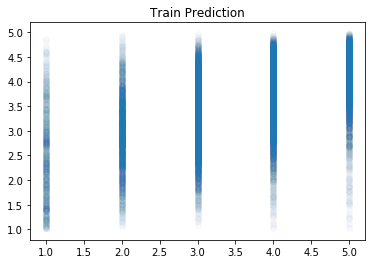

In [24]:
plt.scatter(true, preds.detach(), alpha=.01)
plt.title('Train Prediction')
print(spearmanr(true, preds.detach()))